In [1]:
import sys; sys.path.append('/rds/general/user/cb2714/home/wwa/'); from wwa import *

In [2]:
sf = gpd.read_file("sf_se-cali/")
xn, xx, yn, yx = [-125,-110,30,40]
la = [-118.24, 34.05]

mapproj = cartopy.crs.PlateCarree()

states = regionmask.defined_regions.natural_earth_v5_0_0.us_states_50.to_geodataframe().clip((xn,yn,xx,yx))

# Shapefile for study region

In [163]:
# load GACC shapefile
sf = gpd.read_file("sf_gacc").to_crs(epsg = 4326).iloc[[8]]

# select single largest polygon
sf = sf.explode(index_parts = False)
sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]

/var/tmp/pbs.462676.pbs/ipykernel_1840304/3199642677.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  sf = sf.loc[[a == sf.geometry.area.max() for a in sf.geometry.area]]


In [164]:
# make a polygon to bisect the region
lats = [34,37.25,37.25,32,32]
lons = [-119.5, -116.5, -114, -114, -119.5]

polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[Polygon(zip(lons, lats))])

<AxesSubplot: >

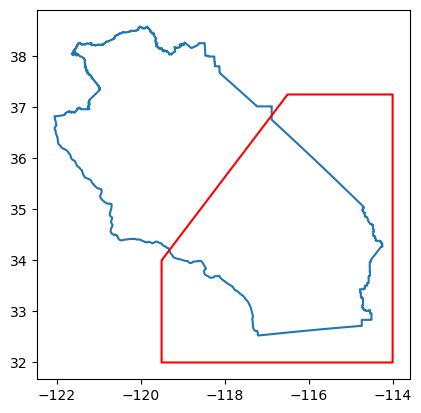

In [165]:
sf.boundary.plot()
polygon.boundary.plot(ax = plt.gca(), color = "red")

In [167]:
sf = sf.to_crs(epsg = 4326).clip(polygon)
sf.to_file("sf_se-cali")

# Physical geography

In [114]:
elev = wrap_lon(xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/live/data/elev.0.25-deg.nc", decode_times = False).squeeze(drop = True).data).sel(lon = slice(xn,xx), lat = slice(yn,yx))

gacc = gpd.read_file("sf_gacc").to_crs(epsg = 4326).iloc[[8]]

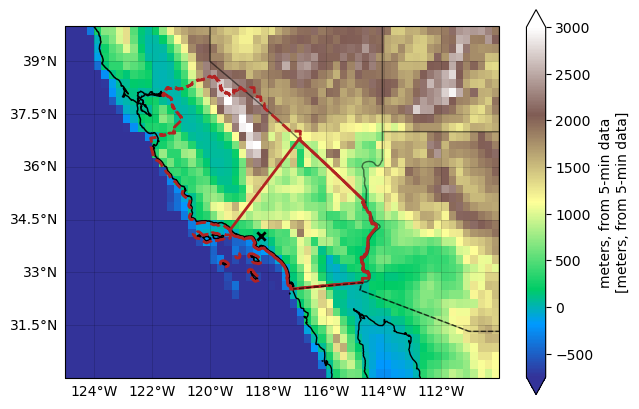

In [116]:
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (7,5), dpi = 100, subplot_kw = {"projection" : mapproj})

elev.plot(ax = ax, cmap = "terrain", vmin = -750, vmax = 3000)

ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
ax.coastlines()

gacc.boundary.plot(ax = ax, color = "firebrick", lw = 2, ls = "--")
sf.boundary.plot(ax = ax, color = "firebrick", lw = 2)
ax.scatter(*la, marker = "x", color = "k", lw = 2)

# ERA5 Orography

In [111]:
orog = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/era5_orography.nc").reset_coords(drop = True).squeeze(drop = True)
orog = orog.where(orog.isor > 0)

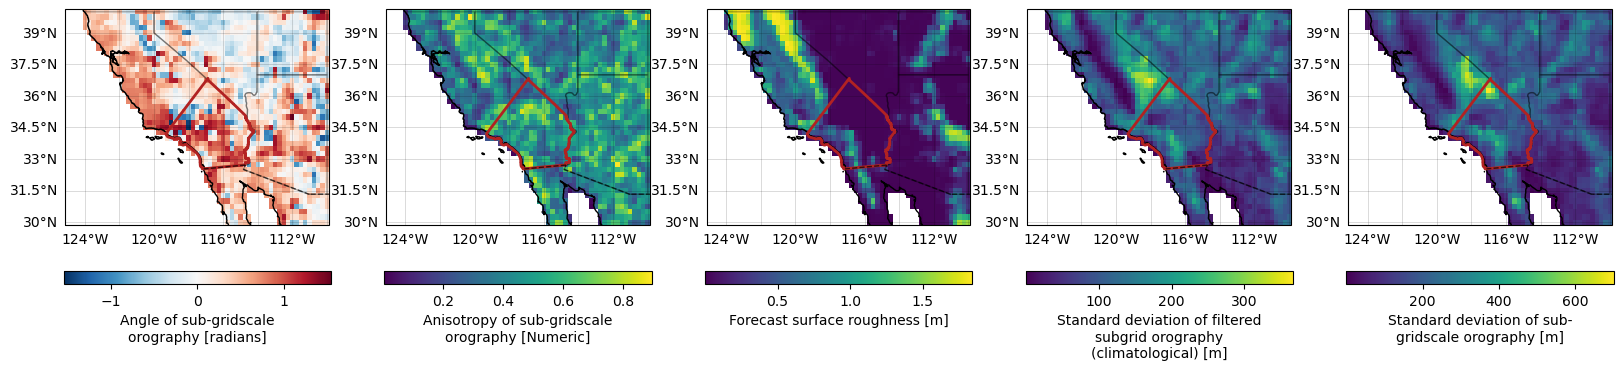

In [112]:
fig, axs = plt.subplots(ncols = 5, figsize = (20,4), subplot_kw = {"projection" : mapproj})

for i in range(5):
    ax = axs[i]
    varnm = list(orog.data_vars)[i]
    orog[varnm].plot(ax = ax, cbar_kwargs = {"location" : "bottom"})
    
    ax.gridlines(crs=cartopy.crs.PlateCarree(), linewidth=0.5, color='black', draw_labels=["bottom", "left"], alpha=0.2)
    states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    ax.coastlines()

    sf.boundary.plot(ax = ax, color = "firebrick", lw = 2)

# Event maps

## FWI (MSWX)

In [146]:
da = xr.open_dataset("/rds/general/user/cb2714/home/00_WWA_project_folder/ephemeral/cali-wildfires/mswx/fwi_mswx_2024-2025.nc")

vcols = {"dc" : "Oranges", "dmc" : "Oranges", "ffmc" : "Oranges", "isi" : "Oranges", "bui" : "Oranges", "fwi" : "Oranges"}
vmaxes = {"dc" : 2500, "dmc" : 1500, "ffmc": 100, "isi" : 500, "bui" : 1500, "fwi" : 500}

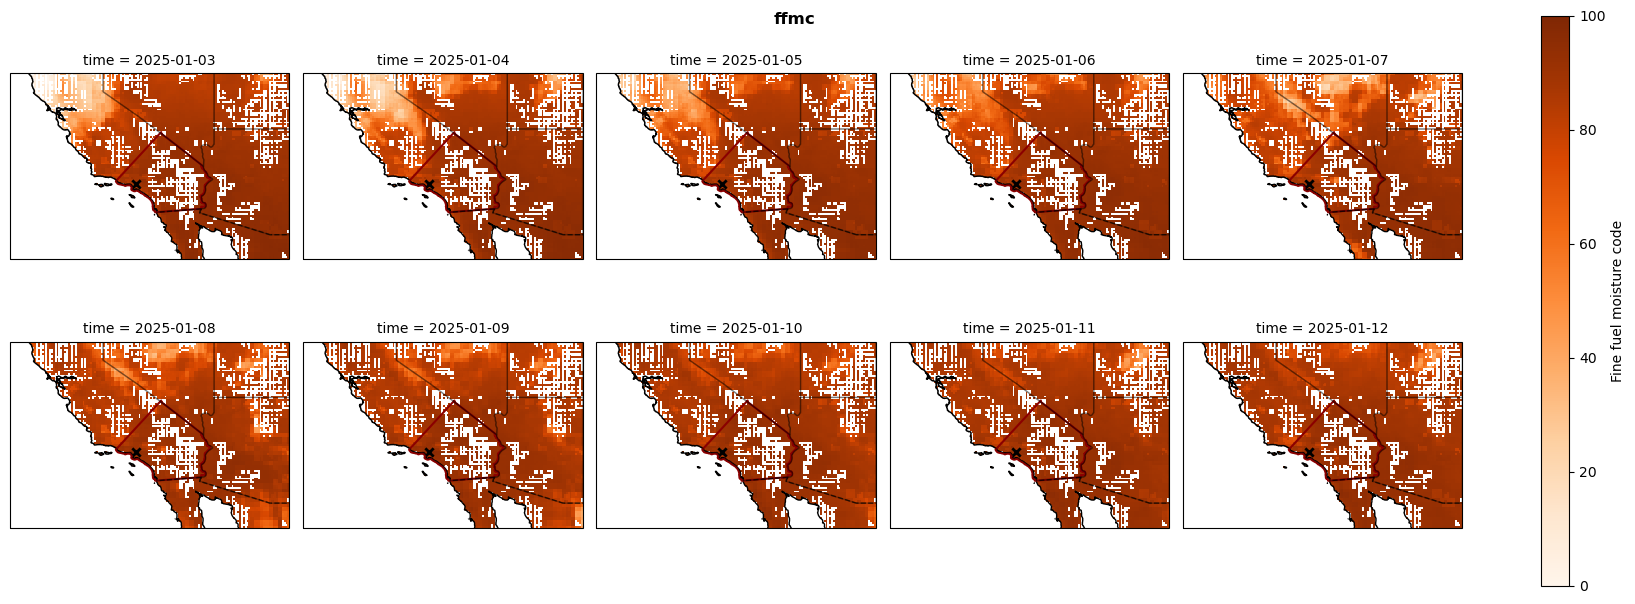

In [147]:
varnm = "ffmc"

fig = da[varnm].sel(time = slice("2025-01-03", None)).plot(col = "time", col_wrap = 5, subplot_kws = {"projection" : mapproj}, cmap = vcols[varnm], vmin = 0, vmax = vmaxes[varnm],
                                        cbar_kwargs = {"fraction" : 0.025}, sharex = True, sharey = True)
plt.suptitle(varnm, fontweight = "bold")

for ax in fig.axs.flat:
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
    ax.scatter(*la, marker = "x", color = "k", lw = 2)
    states.boundary.plot(ax = ax, color = "k", alpha = 0.3, lw = 1)
    ax.add_feature(cartopy.feature.BORDERS, lw = 1, alpha = 0.7, ls = "--", zorder = 99)
    
plt.savefig("/rds/general/user/cb2714/home/wwa/25-01_california-wildfires/fig/event-map_"+varnm+"-2025_mswx.png")

# Seasonal precip

In [3]:
era5l = xr.open_dataset("data/era5land_precip-pet_monthly_se-cali.nc")
era5 = xr.open_dataset("data/era5_precip-pet_monthly_se-cali.nc")